In [82]:
!pip list | grep "torch\|tensorflow\|transformers\|opencv\|scikit-learn"


opencv-contrib-python              4.10.0.84
opencv-python                      4.10.0.84
opencv-python-headless             4.10.0.84
pytorch-ignite                     0.5.1
pytorch-lightning                  2.5.0.post0
scikit-learn                       1.2.2
scikit-learn-intelex               2025.2.0
sentence-transformers              3.3.1
tensorflow                         2.17.1
tensorflow-cloud                   0.1.5
tensorflow-datasets                4.9.7
tensorflow_decision_forests        1.10.0
tensorflow-hub                     0.16.1
tensorflow-io                      0.37.1
tensorflow-io-gcs-filesystem       0.37.1
tensorflow-metadata                1.13.1
tensorflow-probability             0.24.0
tensorflow-text                    2.17.0
torch                              2.5.1+cu121
torchaudio                         2.5.1+cu121
torchinfo                          1.8.0
torchmetrics                       1.6.1
torchsummary                       1.5.1
torchtune       

In [83]:
!apt-get update
!apt-get install -y fonts-noto


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease                                              
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease                                      
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease         
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease                                    
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease                                          
Hit:7 http://security.ubuntu.com/ubuntu jammy-security InRelease                                    
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease     
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/so

In [84]:
!pip install torch torchvision transformers opencv-python scikit-learn thop

In [85]:
import pandas as pd

# Load the CSV file
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTyh006zrmSWoKAwqF92kZ4lvNRKsZL5NYIkdSEK3wtrWA8yMKLT6K3h1k1nyyHjG9ntZvc9tTcbUif/pub?output=csv'
df = pd.read_csv(url,encoding="utf-8")
df.head()


,id,caption,label,level,area,Unnamed: 5
0,1,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1.0,NaN,NaN
1,2,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1.0,NaN,NaN
2,3,কুমিল্লা,flood,1.0,কুমিল্লা,NaN
3,4,আখাউড়া উপজেলা ও কসবা উপজেলা'র বিভিন্ন এলাকায় ই...,flood,1.0,আখাউড়া,NaN
4,5,ফেনীর মুহুরী নদীতে পানির মাত্রা গত ৪০ বছরের ইত...,flood,1.0,ফেনী,NaN


In [86]:
# Verify column names
print(df.columns)

Index([' id', 'caption', 'label', 'level', 'area', 'Unnamed: 5'], dtype='object')


In [87]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaModel
from torchvision import transforms, models
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
from thop import profile

In [88]:
# Drop unnecessary columns if they exist
columns_to_drop = [col for col in ['level', 'area', 'Unnamed: 5'] if col in df.columns]
df = df.drop(columns_to_drop, axis=1)

# Shuffle the dataframe
df = shuffle(df, random_state=42)

In [89]:
df.head()

,id,caption,label
4677,4678,এ যেন এক সুগন্ধির মহাকাব্য!\nযার পঙক্তিমালায় র...,Non Informative
2042,2043,জন্মদিনে ১২ ফ্লেভারের ৩৬ ইঞ্চি পিৎজা পাবেন,Non Informative
410,411,মংলায় ঝড়ের তাণ্ডবে বিদ্যুতের লাইন বিচ্ছিন্ন,Cyclone
4607,4608,"ফটিকছড়ি, বাংলাদেশের চট্টগ্রাম বিভাগ এর একটি উ...",Non Informative
1483,1484,ফিনল্যান্ডের উপকূলে প্লাস্টিক ও রাসায়নিক বর্জ...,Anthropogenic


In [90]:
# Define label mapping
label_mapping = {
    'River Erosion': 3,
    'Cyclone': 1,
    'Anthropogenic': 4,
    'flood': 0,
    'Earthquake': 2,
    'Non Informative': -1  # Will be filtered out
}

# Apply label mapping and remove 'Non Informative' rows
df['label'] = df['label'].map(label_mapping)
df = df[df['label'] != -1].reset_index(drop=True)

In [91]:
# Split the dataset
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

train_data, val_test = train_test_split(df, train_size=train_ratio, random_state=42)
valid_data, test_data = train_test_split(val_test, train_size=val_ratio / (val_ratio + test_ratio), random_state=42)

In [92]:
train_data.columns = train_data.columns.str.strip()
valid_data.columns = valid_data.columns.str.strip()
test_data.columns = test_data.columns.str.strip()


In [93]:
# Define image transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

In [94]:
class MultimodalDataset(Dataset):
    def __init__(self, dataframe, images_folder, tokenizer, image_transforms):
        self.dataframe = dataframe
        self.images_folder = images_folder
        self.tokenizer = tokenizer
        self.image_transforms = image_transforms
        self.class_to_index = {
            'flood': 0,
            'cyclone': 1,
            'earthquake': 2,
            'river erosion': 3,
            'anthropogenic': 4
        }
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        text = str(row['caption'])
        label = int(row['label'])
        image_id = str(row['id']).strip()

        image_path = os.path.join(self.images_folder, f"{image_id}.jpg")
        if not os.path.exists(image_path):
            image_path = os.path.join(self.images_folder, f"{image_id}.png")
        if not os.path.exists(image_path):
            image_path = os.path.join(self.images_folder, f"{image_id}.jpeg")
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image {image_id} not found")

        image = Image.open(image_path).convert('RGB')
        image = self.image_transforms(image)
        text_inputs = self.tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=128)

        assert 0 <= label <= 4, f"Label {label} out of range"

        return {
            'input_ids': text_inputs['input_ids'].squeeze(),
            'attention_mask': text_inputs['attention_mask'].squeeze(),
            'image': image,
            'label': torch.tensor(label, dtype=torch.long),
            'original_label': self.index_to_class[label]
        }

In [95]:
images_folder = '/kaggle/input/mddb-images/Photos_Final'  # Updated to match dataset source
train_dataset = MultimodalDataset(train_data, images_folder, tokenizer, train_transforms)
valid_dataset = MultimodalDataset(valid_data, images_folder, tokenizer, valid_test_transforms)
test_dataset = MultimodalDataset(test_data, images_folder, tokenizer, valid_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [96]:

print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

1596
532
533


In [97]:
# Early Fusion Model
class EarlyFusionModel(nn.Module):
    def __init__(self, num_classes=5, roberta_model_name='xlm-roberta-base', efficientnet_model='efficientnet_b0'):
        super(EarlyFusionModel, self).__init__()
        
        # Text branch: XLM-RoBERTa
        self.roberta = XLMRobertaModel.from_pretrained(roberta_model_name)
        
        # Image branch: EfficientNet
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        in_features = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Identity()  # Remove original classifier
        
        # Combined fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(768 + in_features, 512),  # Concatenate RoBERTa (768) and EfficientNet features
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, input_ids, attention_mask, image):
        # Text features
        text_outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_outputs.pooler_output  # [CLS] token embedding (768-dim)
        
        # Image features
        image_features = self.efficientnet(image)  # Extract image features
        
        # Early fusion: Concatenate features
        combined_features = torch.cat((text_features, image_features), dim=1)
        output = self.fc(combined_features)
        
        return output

In [98]:
# Initialize model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EarlyFusionModel(num_classes=5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

# Training loop with early stopping
num_epochs = 10
train_losses = []
valid_losses = []
best_valid_loss = float('inf')
best_model_path = 'best_model.pth'
patience = 3
early_stop_counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * input_ids.size(0)

    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for batch in valid_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * input_ids.size(0)

    valid_loss /= len(valid_dataset)
    valid_losses.append(valid_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {valid_loss:.4f}")

    # Save best model and check for early stopping
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), best_model_path)
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

# Load best model for evaluation
model.load_state_dict(torch.load(best_model_path))
# model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10: 100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


Epoch 1/10, Train Loss: 1.5889, Val Loss: 1.5375


Epoch 2/10: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


Epoch 2/10, Train Loss: 1.4298, Val Loss: 1.2014


Epoch 3/10: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


Epoch 3/10, Train Loss: 0.8828, Val Loss: 0.5996


Epoch 4/10: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


Epoch 4/10, Train Loss: 0.5045, Val Loss: 0.4061


Epoch 5/10: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s]


Epoch 5/10, Train Loss: 0.3493, Val Loss: 0.2917


Epoch 6/10: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


Epoch 6/10, Train Loss: 0.2179, Val Loss: 0.2823


Epoch 7/10: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


Epoch 7/10, Train Loss: 0.2201, Val Loss: 0.2949


Epoch 8/10: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


Epoch 8/10, Train Loss: 0.1474, Val Loss: 0.2458


Epoch 9/10: 100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


Epoch 9/10, Train Loss: 0.1419, Val Loss: 0.2226


Epoch 10/10: 100%|██████████| 100/100 [01:17<00:00,  1.30it/s]


Epoch 10/10, Train Loss: 0.1138, Val Loss: 0.2188


<ipython-input-98-34a5975dd031>:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


EarlyFusionModel(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
   


Test Set Evaluation:
Accuracy: 0.9268
Precision: 0.9280
Recall: 0.9268
F1 Score: 0.9268

Classification Report:
               precision    recall  f1-score   support

        flood       0.94      0.86      0.90       105
      cyclone       0.87      0.91      0.89       101
   earthquake       0.97      0.94      0.95       118
river erosion       0.89      0.94      0.92        86
anthropogenic       0.96      0.98      0.97       123

     accuracy                           0.93       533
    macro avg       0.92      0.93      0.92       533
 weighted avg       0.93      0.93      0.93       533



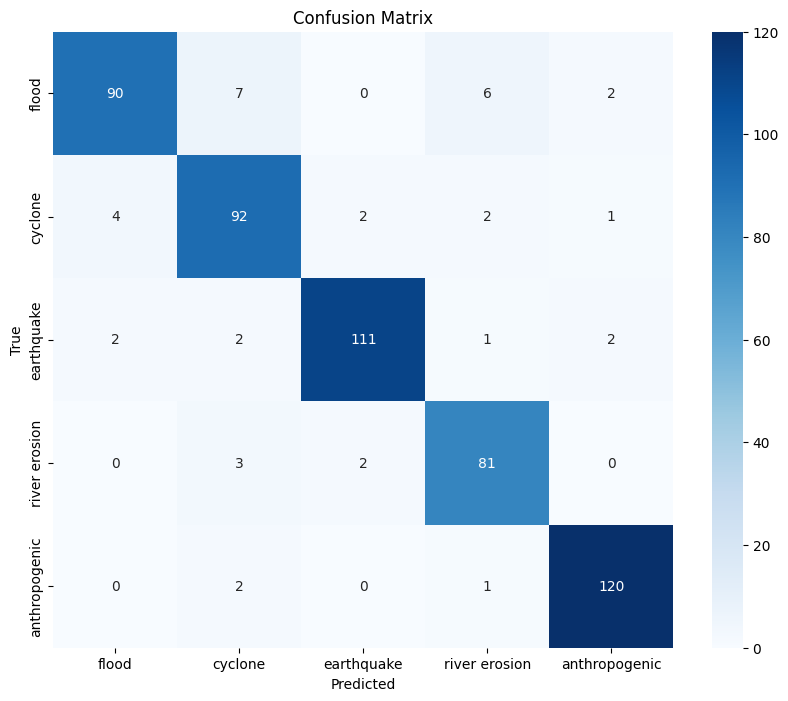

In [99]:
# Evaluation on test set
true_labels = []
pred_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask, images)
        _, preds = torch.max(outputs, dim=1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Compute metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')

print("\nTest Set Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=['flood', 'cyclone', 'earthquake', 'river erosion', 'anthropogenic']))

# Plot confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['flood', 'cyclone', 'earthquake', 'river erosion', 'anthropogenic'], yticklabels=['flood', 'cyclone', 'earthquake', 'river erosion', 'anthropogenic'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

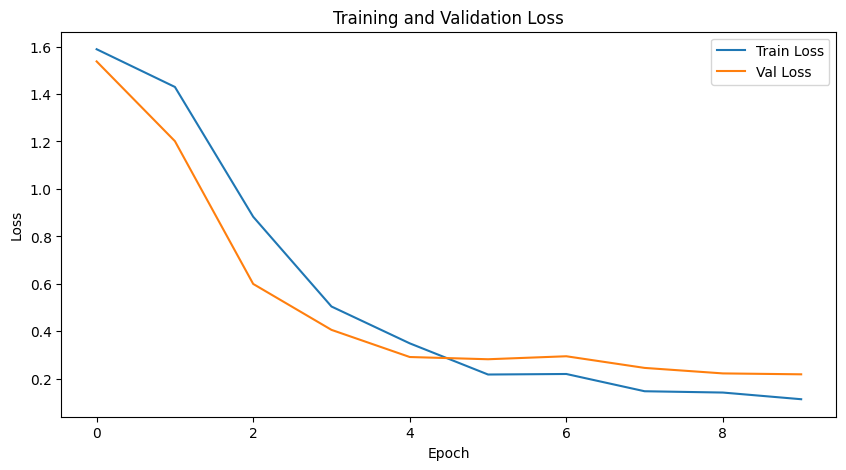

[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.

Model Statistics:
Total Parameters: 90.84M
Total FLOPs: 11.30B


In [103]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Profile the model and display total parameters and FLOPs
dummy_input_ids = torch.randint(0, 1000, (1, 128)).to(device)
dummy_attention_mask = torch.ones(1, 128).to(device)
dummy_image = torch.randn(1, 3, 224, 224).to(device)
flops, params = profile(model, inputs=(dummy_input_ids, dummy_attention_mask, dummy_image))
print(f"\nModel Statistics:")
print(f"Total Parameters: {params / 1e6:.2f}M")
print(f"Total FLOPs: {flops / 1e9:.2f}B")